# Link prediction example: GraphSAGE on the Cora citation dataset

In this example, we use our implementation of the [GraphSAGE](http://snap.stanford.edu/graphsage/) algorithm to build a model that predicts citation links in the Cora dataset (see below). The problem is treated as a supervised link prediction problem on a homogeneous citation network with nodes representing papers (with attributes such as binary keyword indicators and categorical subject) and links corresponding to paper-paper citations. 

To address this problem, we build a model with the following architecture. First we build a two-layer GraphSAGE model that takes labeled `(paper1, paper2)` node pairs corresponding to possible citation links, and outputs a pair of node embeddings for the `paper1` and `paper2` nodes of the pair. These embeddings are then fed into a link classification layer, which first applies a binary operator to those node embeddings (e.g., concatenating them) to construct the embedding of the potential link. Thus obtained link embeddings are passed through the dense link classification layer to obtain link predictions - probability for these candidate links to actually exist in the network. The entire model is trained end-to-end by minimizing the loss function of choice (e.g., binary cross-entropy between predicted link probabilities and true link labels, with true/false citation links having labels 1/0) using stochastic gradient descent (SGD) updates of the model parameters, with minibatches of 'training' links fed into the model.

**References**

[1] Inductive Representation Learning on Large Graphs, W. L. Hamilton, R. Ying, and J. Leskovec, NIPS 2017


Copyright 2010-2019 Commonwealth Scientific and Industrial Research Organisation (CSIRO).

All Rights Reserved.

In [1]:
import networkx as nx
import pandas as pd
import os
import keras 
import numpy as np
import stellargraph as sg
import seaborn as sns
import sklearn
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from sklearn import preprocessing, feature_extraction, model_selection

Using TensorFlow backend.


### Loading the CORA network data

### Dataset


The dataset is the citation network Cora.

It can be downloaded by clicking [here](https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz)

The following is the description of the dataset from the publisher,

> The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words. The README file in the dataset provides more details. 

For this demo, we ignore the word vectors associated with each paper. We are only interested in the network structure and the **subject** attribute of each paper.

Download and unzip the cora.tgz file to a location on your computer. 

We assume that the dataset is stored in the directory

`../data/cora/`

where the files `cora.cites` and `cora.content` can be located.

We are going to load the data into a networkx object.

In [2]:
data_dir = os.path.expanduser("../data/cora")

Load the edgelist from the `.cites` file

In [3]:
edgelist = pd.read_csv(os.path.join(data_dir, "cora.cites"), sep='\t', header=None, names=["source", "target"])

Next we create a networkx object from this edgelist:

In [4]:
g_nx = nx.from_pandas_edgelist(edgelist)

The node features and subject are in a seperate file. We load this using pandas:

In [5]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_csv(os.path.join(data_dir, "cora.content"), sep='\t', header=None, names=column_names)

The node features are the numeric features, not including the subject:

In [6]:
node_features = node_data[feature_names]

### Creating test/train pairs

We need to prepare a set of links for training and testing the model. To do this we are going to remove some edges from our input graph that we will use as *positive pairs* and in addition we generate some node pairs that are not in the graph randomly that we will use as *negative pairs*.  These pairs are split into train and test sets.

The link-prediction model is a binary classifier that, given two nodes, predicts whether a link between these two nodes should exist or not.

We will train and test the link prediction model in a graph that has the same nodes as the input graph, but with the positive links removed.

Shuffle the edgelist:

In [7]:
edgelist = np.random.permutation(edgelist)

Select 500 edges as positive pairs. Note that this will likely make the graph disconnected. This is not an issue for the GraphSAGE algorithm, but can make other algorithms (such as node2vec) not work correctly. See "Alternative Edge Splitting" below for a way to split edges leaving the graph connected.

In [8]:
positive_pairs = edgelist[:500]
remaining_links = edgelist[500:]

Randomly choose negative links:

In [9]:
all_nodes = list(node_data.index)
negative_pairs = np.vstack([np.random.choice(all_nodes, size=500), np.random.choice(all_nodes, size=500)]).T

Create our training & test sets from the randomly selected positive and negative links:

In [10]:
all_pairs = np.vstack([positive_pairs, negative_pairs])
all_labels = np.hstack([np.ones(positive_pairs.shape[0]), np.zeros(negative_pairs.shape[0])])

In [11]:
train_pairs, test_pairs, train_labels, test_labels = model_selection.train_test_split(all_pairs, all_labels, train_size=0.5, random_state=42)

Let's create a graph from the remaining links

In [12]:
g_nx = nx.Graph()
g_nx.add_nodes_from(all_nodes)
g_nx.add_edges_from(remaining_links)

Note that the distribution of shortest-path lengths for the positive and negative pairs are different. This can make the problem of separating positive and negative pairs easier than in general.

In [13]:
def pair_distance(G, pairs, ignore_disconnected=True):
    pair_distance = []
    for n1,n2 in pairs:
        try:
            l = nx.shortest_path_length(G, n1, n2)
        except:
            l = -1
        if not ignore_disconnected or l >= 0:
            pair_distance.append(l)
    return pair_distance

In [14]:
pp_distance = pair_distance(g_nx, positive_pairs)
np_distance = pair_distance(g_nx, negative_pairs)

In [15]:
sns.set(color_codes=True)

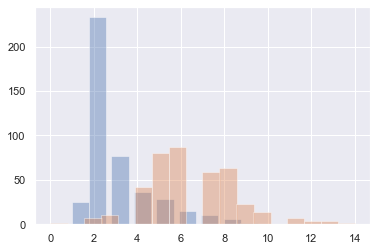

In [16]:
sns.distplot(pp_distance, kde=False, hist_kws={"width":0.8});
sns.distplot(np_distance, kde=False, hist_kws={"width":0.8});

### Traditional link-prediction

In [17]:
train_scores = np.array([x[2] for x in nx.adamic_adar_index(g_nx, train_pairs)])

In [18]:
test_scores = np.array([x[2] for x in nx.adamic_adar_index(g_nx, test_pairs)])

In [19]:
sklearn.metrics.accuracy_score(train_labels, train_scores > 0)

0.73

In [20]:
sklearn.metrics.accuracy_score(test_labels, test_scores > 0)

0.752

### Creating the link prediction model

In [21]:
G = sg.StellarGraph(g_nx, node_features=node_features)

Next, we create the link mappers for sampling and streaming training and testing data to the model. The link mappers essentially "map" pairs of nodes `(paper1, paper2)` to the input of GraphSAGE: they take minibatches of node pairs, sample 2-hop subgraphs with `(paper1, paper2)` head nodes extracted from those pairs, and feed them, together with the corresponding binary labels indicating whether those pairs represent true or false citation links, to the input layer of the GraphSAGE model, for SGD updates of the model parameters.

Specify the minibatch size (number of node pairs per minibatch) and the number of epochs for training the model:

In [22]:
batch_size = 20
epochs = 20

Specify the sizes of 1- and 2-hop neighbour samples for GraphSAGE:

Note that the length of `num_samples` list defines the number of layers/iterations in the GraphSAGE model. In this example, we are defining a 2-layer GraphSAGE model.

In [23]:
num_samples = [20, 10]

In [24]:
link_generator = GraphSAGELinkGenerator(G, batch_size, num_samples)
train_gen = link_generator.flow(train_pairs, train_labels)
test_gen = link_generator.flow(test_pairs, test_labels)

Build the model: a 2-layer GraphSAGE model acting as node representation learner, with a link classification layer on concatenated `(paper1, paper2)` node embeddings.

GraphSAGE part of the model, with hidden layer sizes of 50 for both GraphSAGE layers, a bias term, and no dropout. (Dropout can be switched on by specifying a positive dropout rate, 0 < dropout < 1)
Note that the length of layer_sizes list must be equal to the length of num_samples, as len(num_samples) defines the number of hops (layers) in the GraphSAGE model.

In [25]:
graphsage = GraphSAGE(
        layer_sizes=[16, 16], generator=train_gen, bias=True, dropout=0.3
    )

In [26]:
x_inp, x_out = graphsage.build()



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Final link classification layer that takes a pair of node embeddings produced by graphsage, applies a binary operator to them to produce the corresponding link embedding ('ip' for inner product; other options for the binary operator can be seen by running a cell with `?link_classification` in it), and passes it through a dense layer:

In [27]:
prediction = link_classification(
        output_dim=1, output_act="relu", edge_embedding_method='ip'
    )(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


Stack the GraphSAGE and prediction layers into a Keras model, and specify the loss

In [28]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.binary_crossentropy,
        metrics=["acc"],
    )



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Evaluate the initial (untrained) model on the train and test set:

In [29]:
init_train_metrics = model.evaluate_generator(train_gen)
init_test_metrics = model.evaluate_generator(test_gen)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Train Set Metrics of the initial (untrained) model:
	loss: 1.0353
	acc: 0.5740

Test Set Metrics of the initial (untrained) model:
	loss: 0.8903
	acc: 0.5840


Now we train the model using the training generator to feed the features for the node pairs:

In [30]:
history = model.fit_generator(
        train_gen,
        epochs=epochs,
        validation_data=test_gen,
        verbose=2
    )

Epoch 1/20
 - 6s - loss: 1.2135 - acc: 0.5160 - val_loss: 0.7361 - val_acc: 0.5800
Epoch 2/20
 - 5s - loss: 0.6834 - acc: 0.6460 - val_loss: 0.6742 - val_acc: 0.5880
Epoch 3/20
 - 5s - loss: 0.7145 - acc: 0.6840 - val_loss: 0.6712 - val_acc: 0.6060
Epoch 4/20
 - 5s - loss: 0.5155 - acc: 0.7640 - val_loss: 0.6015 - val_acc: 0.6520
Epoch 5/20
 - 5s - loss: 0.4957 - acc: 0.7900 - val_loss: 0.5701 - val_acc: 0.6720
Epoch 6/20
 - 5s - loss: 0.3923 - acc: 0.8340 - val_loss: 0.5572 - val_acc: 0.6920
Epoch 7/20
 - 5s - loss: 0.3502 - acc: 0.8660 - val_loss: 0.5427 - val_acc: 0.6960
Epoch 8/20
 - 5s - loss: 0.3327 - acc: 0.9140 - val_loss: 0.5321 - val_acc: 0.7020
Epoch 9/20
 - 5s - loss: 0.3009 - acc: 0.8840 - val_loss: 0.5127 - val_acc: 0.7360
Epoch 10/20
 - 5s - loss: 0.2568 - acc: 0.9340 - val_loss: 0.5142 - val_acc: 0.7320
Epoch 11/20
 - 5s - loss: 0.2873 - acc: 0.9160 - val_loss: 0.5068 - val_acc: 0.7440
Epoch 12/20
 - 5s - loss: 0.2263 - acc: 0.9340 - val_loss: 0.5527 - val_acc: 0.7600
E

Plot the training history:

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    metrics = sorted(history.history.keys())
    metrics = metrics[:len(metrics)//2]
    
    f,axs = plt.subplots(1, len(metrics), figsize=(12,4))

    for m,ax in zip(metrics,axs):
        # summarize history for metric m
        ax.plot(history.history[m])
        ax.plot(history.history['val_' + m])
        ax.set_title(m)
        ax.set_ylabel(m)
        ax.set_xlabel('epoch')
        ax.legend(['train', 'test'], loc='upper right')

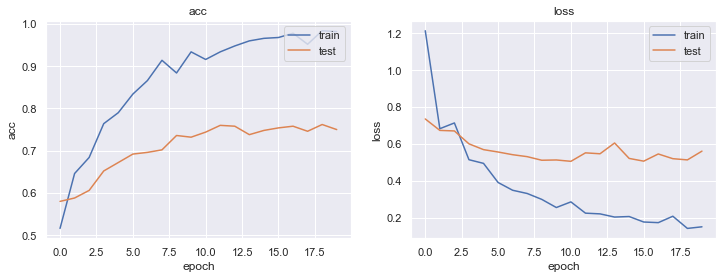

In [32]:
plot_history(history)

Evaluate the trained model on test citation links:

In [33]:
train_metrics = model.evaluate_generator(train_gen)
test_metrics = model.evaluate_generator(test_gen)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Train Set Metrics of the trained model:
	loss: 0.0723
	acc: 0.9980

Test Set Metrics of the trained model:
	loss: 0.6034
	acc: 0.7480


## Alternative Edge Splitting

We aim to train a link prediction model, hence we need to prepare the train and test sets of links and the corresponding graphs with those links removed.

We are going to split our input graph into a train and test graphs using the EdgeSplitter class in `stellargraph.data`. We will use the train graph for training the model (a binary classifier that, given two nodes, predicts whether a link between these two nodes should exist or not) and the test graph for evaluating the model's performance on hold out data.
Each of these graphs will have the same number of nodes as the input graph, but the number of links will differ (be reduced) as some of the links will be removed during each split and used as the positive samples for training/testing the link prediction classifier.

From the original graph G, extract a randomly sampled subset of test edges (true and false citation links) and the reduced graph G_test with the positive test edges removed:

In [34]:
g_nx = nx.Graph()
g_nx.add_nodes_from(all_nodes)
g_nx.add_edges_from(edgelist)

In [35]:
# Define an edge splitter on the original graph g_nx:
edge_splitter_test = EdgeSplitter(g_nx)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="local", keep_connected=True, probs=[0.25,0.25,0.25,0.25]
)

** Sampled 527 positive and 527 negative edges. **


The reduced graph G_test, together with the test ground truth set of links (edge_ids_test, edge_labels_test), will be used for testing the model.

Now repeat this procedure to obtain the training data for the model. From the reduced graph G_test, extract a randomly sampled subset of train edges (true and false citation links) and the reduced graph G_train with the positive train edges removed:

In [36]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="local", keep_connected=True,  probs=[0.25,0.25,0.25,0.25]
)

** Sampled 475 positive and 475 negative edges. **


G_train, together with the train ground truth set of links (edge_ids_train, edge_labels_train), will be used for training the model.

Notice the shortest path distances between node pairs are now similar:

In [38]:
pp_distance = pair_distance(G_test, edge_ids_test[edge_labels_test==1])
np_distance = pair_distance(G_test, edge_ids_test[edge_labels_test==0])

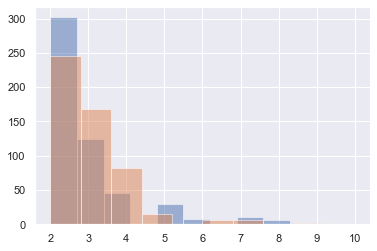

In [39]:
plt.hist(pp_distance, alpha=0.5);
plt.hist(np_distance, alpha=0.5);

### Traditional link-prediction

In [40]:
train_scores = np.array([x[2] for x in nx.adamic_adar_index(G_train, edge_ids_train)])

In [41]:
sum(train_scores*edge_labels_train)/sum(edge_labels_train)

0.4442191327628641

In [42]:
sum(train_scores*(1-edge_labels_train))/sum(1-edge_labels_train)

0.3583024505431669

In [43]:
test_scores = np.array([x[2] for x in nx.adamic_adar_index(G_test, edge_ids_test)])

In [44]:
sklearn.metrics.accuracy_score(edge_labels_train, train_scores > 0)

0.5168421052631579

In [45]:
sklearn.metrics.accuracy_score(edge_labels_test, test_scores > 0)

0.5531309297912713

### GraphSAGE Link Prediction

Convert G_train and G_test to StellarGraph objects (undirected, as required by GraphSAGE) for ML:

In [46]:
G_train = sg.StellarGraph(G_train, node_features=node_features)
G_test = sg.StellarGraph(G_test, node_features=node_features)

Summary of G_train and G_test - note that they have the same set of nodes, only differing in their edge sets:

Next, we create the link mappers for sampling and streaming training and testing data to the model. The link mappers essentially "map" pairs of nodes `(paper1, paper2)` to the input of GraphSAGE: they take minibatches of node pairs, sample 2-hop subgraphs with `(paper1, paper2)` head nodes extracted from those pairs, and feed them, together with the corresponding binary labels indicating whether those pairs represent true or false citation links, to the input layer of the GraphSAGE model, for SGD updates of the model parameters.

Specify the minibatch size (number of node pairs per minibatch) and the number of epochs for training the model:

In [47]:
batch_size = 50
epochs = 20

Specify the sizes of 1- and 2-hop neighbour samples for GraphSAGE:

Note that the length of `num_samples` list defines the number of layers/iterations in the GraphSAGE model. In this example, we are defining a 2-layer GraphSAGE model.

In [48]:
num_samples = [20, 20]

In [49]:
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples).flow(edge_ids_train,edge_labels_train)
test_gen = GraphSAGELinkGenerator(G_test,  batch_size, num_samples).flow(edge_ids_test, edge_labels_test)

Build the model: a 2-layer GraphSAGE model acting as node representation learner, with a link classification layer on concatenated `(paper1, paper2)` node embeddings.

GraphSAGE part of the model, with hidden layer sizes of 50 for both GraphSAGE layers, a bias term, and no dropout. (Dropout can be switched on by specifying a positive dropout rate, 0 < dropout < 1)
Note that the length of layer_sizes list must be equal to the length of num_samples, as len(num_samples) defines the number of hops (layers) in the GraphSAGE model.

In [50]:
layer_sizes = [20, 20]
assert len(layer_sizes) == len(num_samples)

graphsage = GraphSAGE(
        layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
    )

In [51]:
x_inp, x_out = graphsage.build()

Final link classification layer that takes a pair of node embeddings produced by graphsage, applies a binary operator to them to produce the corresponding link embedding ('ip' for inner product; other options for the binary operator can be seen by running a cell with `?link_classification` in it), and passes it through a dense layer:

In [52]:
prediction = link_classification(
        output_dim=1, output_act="sigmoid", edge_embedding_method='ip'
    )(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


Stack the GraphSAGE and prediction layers into a Keras model, and specify the loss

In [53]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.binary_crossentropy,
        metrics=["acc"],
    )

Evaluate the initial (untrained) model on the train and test set:

In [54]:
init_train_metrics = model.evaluate_generator(train_gen)
init_test_metrics = model.evaluate_generator(test_gen)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Train Set Metrics of the initial (untrained) model:
	loss: 0.7110
	acc: 0.5074

Test Set Metrics of the initial (untrained) model:
	loss: 0.7129
	acc: 0.5085


Train the model:

In [55]:
history = model.fit_generator(
        train_gen,
        epochs=epochs,
        validation_data=test_gen,
        verbose=2
    )

Epoch 1/20
 - 31s - loss: 0.7143 - acc: 0.5053 - val_loss: 0.7174 - val_acc: 0.5066
Epoch 2/20
 - 25s - loss: 0.6912 - acc: 0.5400 - val_loss: 0.7042 - val_acc: 0.5237
Epoch 3/20
 - 25s - loss: 0.6651 - acc: 0.6000 - val_loss: 0.7042 - val_acc: 0.5237
Epoch 4/20
 - 25s - loss: 0.6575 - acc: 0.6263 - val_loss: 0.7036 - val_acc: 0.5209
Epoch 5/20
 - 25s - loss: 0.6421 - acc: 0.6589 - val_loss: 0.7050 - val_acc: 0.5218
Epoch 6/20
 - 25s - loss: 0.6234 - acc: 0.7116 - val_loss: 0.7032 - val_acc: 0.5275
Epoch 7/20
 - 25s - loss: 0.6159 - acc: 0.7242 - val_loss: 0.7025 - val_acc: 0.5180
Epoch 8/20
 - 25s - loss: 0.6131 - acc: 0.7263 - val_loss: 0.7013 - val_acc: 0.5361
Epoch 9/20
 - 25s - loss: 0.6021 - acc: 0.7526 - val_loss: 0.7009 - val_acc: 0.5190
Epoch 10/20
 - 26s - loss: 0.5878 - acc: 0.7832 - val_loss: 0.7000 - val_acc: 0.5228
Epoch 11/20
 - 27s - loss: 0.5829 - acc: 0.8126 - val_loss: 0.7037 - val_acc: 0.5351
Epoch 12/20
 - 25s - loss: 0.5771 - acc: 0.8053 - val_loss: 0.7015 - val_a

Plot the training history:

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    metrics = sorted(history.history.keys())
    metrics = metrics[:len(metrics)//2]
    
    f,axs = plt.subplots(1, len(metrics), figsize=(12,4))

    for m,ax in zip(metrics,axs):
        # summarize history for metric m
        ax.plot(history.history[m])
        ax.plot(history.history['val_' + m])
        ax.set_title(m)
        ax.set_ylabel(m)
        ax.set_xlabel('epoch')
        ax.legend(['train', 'test'], loc='upper right')

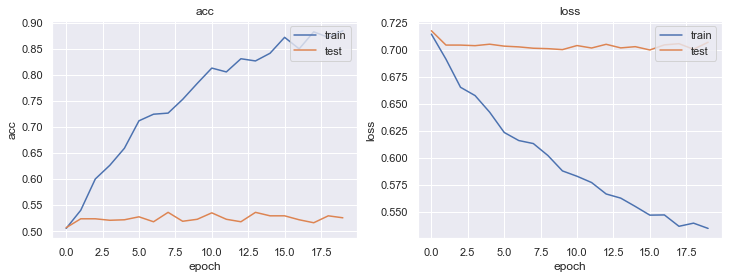

In [57]:
plot_history(history)

Evaluate the trained model on test citation links:

In [58]:
train_metrics = model.evaluate_generator(train_gen)
test_metrics = model.evaluate_generator(test_gen)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Train Set Metrics of the trained model:
	loss: 0.4563
	acc: 0.9632

Test Set Metrics of the trained model:
	loss: 0.7020
	acc: 0.5285
